In [1]:
import pathlib

import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import seaborn as sns
from IPython.display import HTML

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
%aimport src.visualization.clouds

### Header

In [4]:
data_dir = pathlib.Path("../../data").resolve()

data_paths = {
    "lysva-raw": data_dir / "raw" / "lysva",
    "lysva-interim": data_dir / "interim" / "lysva",
    "trees": data_dir / "raw" / "trees",
}

In [5]:
lysva_field_survey = gpd.read_file(data_paths["lysva-raw"] / "field_survey.geojson")
lysva_als_files = sorted((data_paths["lysva-interim"] / "als").glob("*.las"))
lysva_ortho_files = sorted((data_paths["lysva-raw"] / "ortho").glob("*.tif"))

In [6]:
#| include: true
#| label: tbl-inventory-example
#| tbl-cap: Example of data in the field inventory table. Each row is a recorded tree.

display(HTML(lysva_field_survey.sample(5, random_state=1917).to_html(index=False)))

plot,tree_no,species,d1,d2,dbh,age,height,angle,comment,geometry
7.0,111.0,Birch,23.0,23.0,23.00,NaN,NaN,0.0,None,POINT (545784.419 6449359.132)
5.0,136.0,Fir,23.5,23.0,23.25,90.0,17.5,0.0,Rotten,POINT (545721.242 6449901.051)
3.0,119.0,Aspen,36.1,42.1,39.10,89.0,25.5,0.0,None,POINT (546630.326 6450158.241)
9.0,345.0,Spruce,19.7,22.0,20.85,NaN,15.9,0.0,None,POINT (546201.645 6449118.199)
6.0,267.0,Spruce,12.9,12.9,12.90,NaN,NaN,0.0,None,POINT (545568.842 6449407.13)


In [7]:
las = laspy.read(lysva_als_files[9])
xyz = las.xyz
color = np.stack([las.red, las.green, las.blue], axis=1)

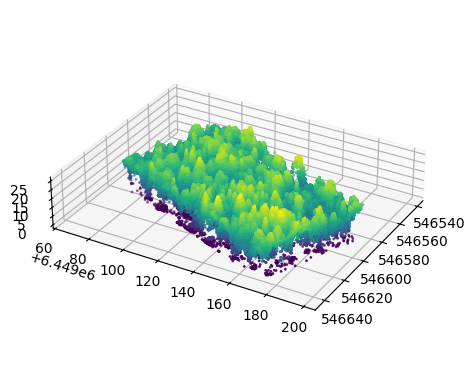

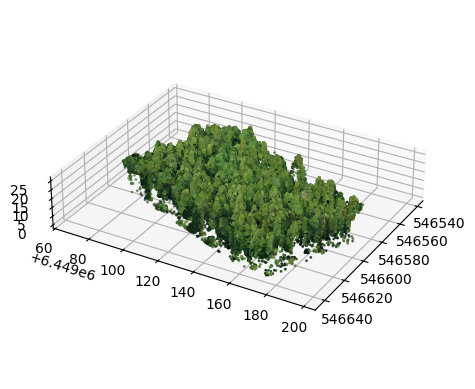

In [8]:
#| include: true
#| label: fig-example-3d-point-cloud
#| layout-ncol: 2
#| fig-cap: A 3D visualisation of a UAV LiDAR point cloud of plot 10.
#| fig-subcap:
#|   - Points colored by height.
#|   - Points assigned color by sampling the orthophoto.

params = {
    "azim": 30,
}

ax = src.visualization.clouds.scatter_point_cloud_3d(xyz, **params)
src.visualization.clouds.scatter_point_cloud_3d(xyz, color=color / 255, **params);

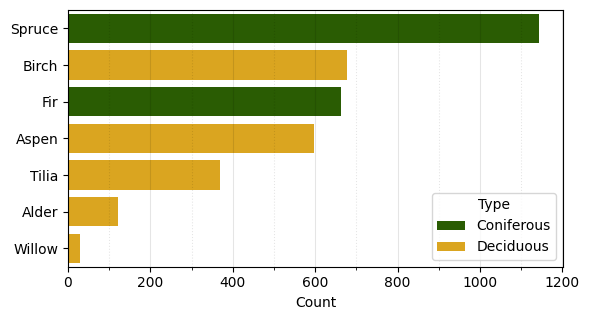

In [9]:
#| include: true
#| label: fig-lysva-species-distribution
#| fig-cap: |
#|  Distribution of species in the Lysva dataset. Dominant species is spruce, but
#|  overall the split between coniferous and decidious species is even.

conifiers = {"Spruce", "Fir", "Pine"}

counts = (
    lysva_field_survey.query("species not in ['Elm', 'Pine']")
    .value_counts("species")
    .reset_index()
)
counts["Type"] = counts["species"].map(
    lambda x: "Coniferous" if x in conifiers else "Deciduous"
)

fig, ax = plt.subplots(figsize=(6, 3.3), tight_layout=True)
ax = sns.barplot(
    data=counts,
    x="count",
    y="species",
    hue="Type",
    dodge=False,
    hue_order=["Coniferous", "Deciduous"],
    palette=["#2A5C03", "#DAA520"],
    saturation=1,
    ax=ax,
)
ax.set_xlabel("Count")
ax.set_ylabel(None)
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.grid(axis="x", color="black", alpha=0.1)
ax.grid(which="minor", axis="x", color="black", alpha=0.1, ls=":")

### On intentisty

Despite it sometimes being reported as an important parameter in classical machine learning on point clouds, I find the intensity to be unreliable.

In [10]:
full_intensity = np.concatenate([laspy.read(x).intensity for x in lysva_als_files])
full_intensity.size, full_intensity.min(), full_intensity.max()

(2739182, 2, 63)

In [11]:
2 ** 6 - 1

63

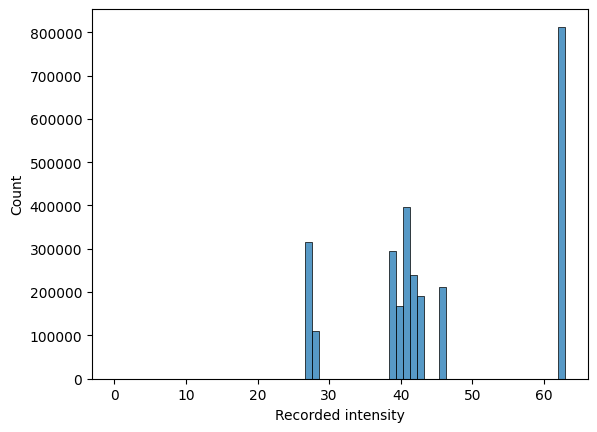

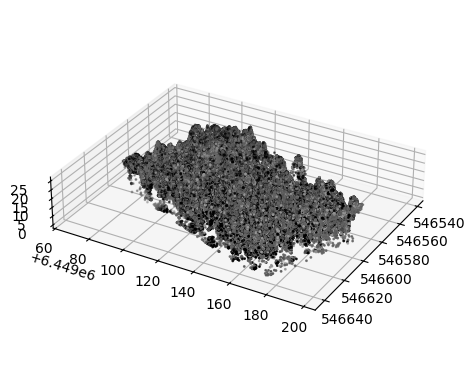

In [12]:
#| include: true
#| label: fig-intensity-with-example
#| layout-ncol: 2
#| fig-cap: An example of the unreliability of the intensity attribute.
#| fig-subcap:
#|   - Distribution of intensity over all points in the Lysva dataset.
#|   - A point cloud of plot 10 with points colored by intensity.

ax = sns.histplot(full_intensity, binrange=(0, 63), bins=64)
ax.set_xlabel("Recorded intensity")
src.visualization.clouds.scatter_point_cloud_3d(
    xyz,
    color=las.intensity,
    **params,
    cmap="binary",
);